In [1]:
import os
import json
from PIL import Image
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
from datetime import datetime

### Load Data

In [2]:
def transform(img_path):
    img = Image.open(img_path)
    img = img.convert('L')
    img = img.resize((224, 224))
    return img

def load_data(json_file, data_dir):
    print(f"loading data from {str(data_dir)}({json_file})")
    imgs = []
    labels = []
    begin = datetime.now()
    with open(json_file, 'r') as f:
        raw_data = json.load(f)
        for data in raw_data:
            imgs.append(os.path.join(data_dir, data['dir']))
            labels.append(data['label'])
    # images to array
    imgs = [transform(img) for img in imgs]
    imgs = [np.array(img).reshape(-1) / 255 - 0.5 for img in imgs]    # zero mean
    print('Time costs {}s'.format((datetime.now() - begin).seconds))
    return np.array(imgs), np.array(labels)

In [3]:
data_dir = os.path.join('..', 'dataset', 'public')
train_json = os.path.join('data', 'public_train.json')
valid_json = os.path.join('data', 'public_valid.json')
test_json = os.path.join('data', 'public_test.json')
imgs_train, labels_train = load_data(train_json, data_dir)
imgs_valid, labels_valid = load_data(valid_json, data_dir)
imgs_test, labels_test = load_data(test_json, data_dir)

loading data from ../dataset/public(data/public_train.json)
Time costs 191s
loading data from ../dataset/public(data/public_valid.json)
Time costs 23s
loading data from ../dataset/public(data/public_test.json)
Time costs 47s


In [4]:
train_data = np.concatenate((imgs_train, imgs_valid))
train_labels = np.concatenate((labels_train, labels_valid))
print(train_data.shape)
print(train_labels.shape)

(1249, 50176)
(1249,)


### SVM classfication

In [5]:
best_model = None
best_acc = 0.

kernels = ['rbf', 'poly', 'linear', 'sigmoid']
C_values = [0.1, 0.5, 1, 2, 10]

for kernel in kernels:
    for C in C_values:

        model = svm.SVC(kernel=kernel, C=C)
        model.fit(train_data, train_labels)

        pred_labels = model.predict(train_data)
        train_acc = accuracy_score(train_labels, pred_labels)
        pred_labels = model.predict(imgs_test)
        test_acc = accuracy_score(labels_test, pred_labels)
        print('kernel: {}    C: {}    Train acc: {:.4g}    Test acc: {:.4g}'.format(kernel, C, train_acc, test_acc))

        if test_acc > best_acc:
            best_acc = test_acc
            best_model = model

kernel: rbf    C: 0.1    Train acc: 0.8647    Test acc: 0.8776
kernel: rbf    C: 0.5    Train acc: 0.8663    Test acc: 0.8776
kernel: rbf    C: 1    Train acc: 0.8951    Test acc: 0.8776
kernel: rbf    C: 2    Train acc: 0.9512    Test acc: 0.8844
kernel: rbf    C: 10    Train acc: 1    Test acc: 0.8878
kernel: poly    C: 0.1    Train acc: 0.8751    Test acc: 0.8776
kernel: poly    C: 0.5    Train acc: 0.9047    Test acc: 0.8673
kernel: poly    C: 1    Train acc: 0.9223    Test acc: 0.8673
kernel: poly    C: 2    Train acc: 0.9424    Test acc: 0.8707
kernel: poly    C: 10    Train acc: 0.9792    Test acc: 0.8571
kernel: linear    C: 0.1    Train acc: 0.9992    Test acc: 0.6667
kernel: linear    C: 0.5    Train acc: 0.9992    Test acc: 0.6531
kernel: linear    C: 1    Train acc: 1    Test acc: 0.6599
kernel: linear    C: 2    Train acc: 1    Test acc: 0.6293
kernel: linear    C: 10    Train acc: 1    Test acc: 0.6224
kernel: sigmoid    C: 0.1    Train acc: 0.8631    Test acc: 0.8776
ker

In [7]:
print(best_model)

SVC(C=10)


### Test Best Model

In [14]:
model = svm.SVC(C=10, probability=True)
model.fit(train_data, train_labels)

SVC(C=10, probability=True)

mAP Curve

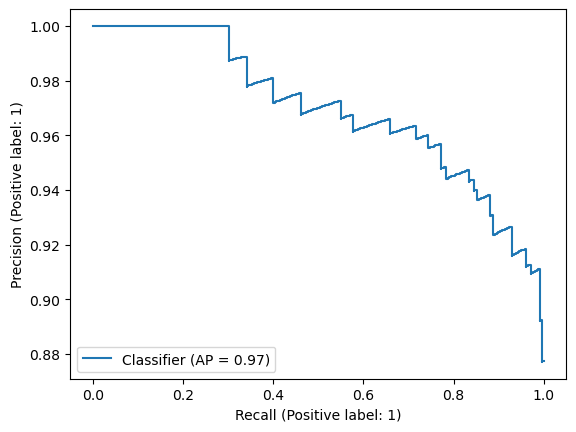

In [21]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

prob_pred = model.predict_proba(imgs_test)[:, 1]
PrecisionRecallDisplay.from_predictions(labels_test, prob_pred)

Precison & Recall

In [23]:
precision, recall, thresholds = precision_recall_curve(labels_test, prob_pred, pos_label=1)
f1 = 2 * precision * recall / (precision + recall)
index = np.argmax(f1)
print(f"[Decided by mAP] Threshold: {thresholds[index]:.4f}  Precision: {precision[index]:.4f}   Recall: {recall[index]:.4f}")

from sklearn.metrics import precision_score, recall_score
labels_pred = model.predict(imgs_test)
print(f"[Decided Directly] Precision: {precision_score(labels_test, labels_pred):.4f}   Recall: {recall_score(labels_test, labels_pred):.4f}")

[Decided by mAP] Threshold: 0.4906  Precision: 0.9110   Recall: 0.9922
[Decided Directly] Precision: 0.9151   Recall: 0.9612


### Test on Tsinghua Dataset

In [24]:
from pathlib import Path

def load_data_from_dir(data_dir):

    imgs = []
    labels = []

    for img_path in Path(data_dir).rglob('*.jpg'):
        img_path = str(img_path)
        label = 0 if 'no_stairs' in img_path else 1
        imgs.append(img_path)
        labels.append(label)

    # images to array
    imgs = [transform(img) for img in imgs]
    imgs = [np.array(img).reshape(-1) / 255 - 0.5 for img in imgs]    # zero mean
    
    return np.array(imgs), np.array(labels)

In [25]:
ROOT = os.path.join("..", "dataset", "tsinghua")
scene1_imgs_test, scene1_labels_test = load_data_from_dir(os.path.join(ROOT, "scene1"))
scene2_imgs_test, scene2_labels_test = load_data_from_dir(os.path.join(ROOT, "scene2"))
scene3_imgs_test, scene3_labels_test = load_data_from_dir(os.path.join(ROOT, "scene3"))
scene4_imgs_test, scene4_labels_test = load_data_from_dir(os.path.join(ROOT, "scene4"))
scene5_imgs_test, scene5_labels_test = load_data_from_dir(os.path.join(ROOT, "scene5"))

test on different scenes

In [27]:
def test_accuracy(model, data, labels):
    labels_pred = model.predict(data)
    acc = accuracy_score(labels, labels_pred)
    print(f"Acc: {acc:.4g}")

print("scene1"), test_accuracy(model, scene1_imgs_test, scene1_labels_test)
print("scene2"), test_accuracy(model, scene2_imgs_test, scene2_labels_test)
print("scene3"), test_accuracy(model, scene3_imgs_test, scene3_labels_test)
print("scene4"), test_accuracy(model, scene4_imgs_test, scene4_labels_test)
print("scene5"), test_accuracy(model, scene5_imgs_test, scene5_labels_test)

scene1
Acc: 0.6846
scene2
Acc: 0.5735
scene3
Acc: 0.5598
scene4
Acc: 0.5558
scene5
Acc: 0.6897


(None, None)

test on total dataset

[Decided by mAP] Threshold: 0.2482  Precision: 0.5811   Recall: 0.9983
[Decided Directly] Precision: 0.5920   Recall: 0.8685


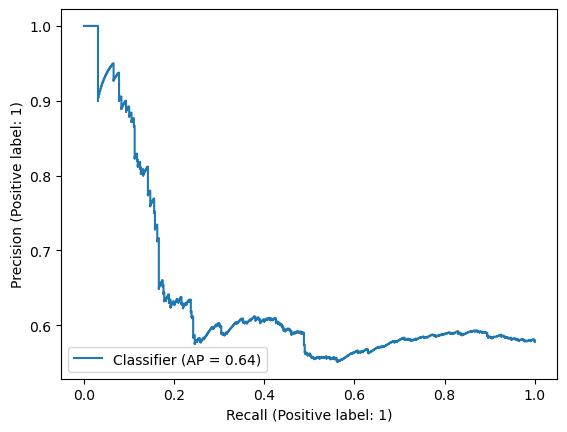

In [30]:
tsinghua_imgs = np.concatenate((scene1_imgs_test, scene2_imgs_test, scene3_imgs_test, scene4_imgs_test, scene5_imgs_test))
tsinghua_labels = np.concatenate((scene1_labels_test, scene2_labels_test, scene3_labels_test, scene4_labels_test, scene5_labels_test))

# mAP curve
prob_pred = model.predict_proba(tsinghua_imgs)[:, 1]
PrecisionRecallDisplay.from_predictions(tsinghua_labels, prob_pred)

# precision and recall
precision, recall, thresholds = precision_recall_curve(tsinghua_labels, prob_pred, pos_label=1)
f1 = 2 * precision * recall / (precision + recall)
index = np.argmax(f1)
print(f"[Decided by mAP] Threshold: {thresholds[index]:.4f}  Precision: {precision[index]:.4f}   Recall: {recall[index]:.4f}")
labels_pred = model.predict(tsinghua_imgs)
print(f"[Decided Directly] Precision: {precision_score(tsinghua_labels, labels_pred):.4f}   Recall: {recall_score(tsinghua_labels, labels_pred):.4f}")